Monte Carlo (random σ, ρ) price: 0.057638

[Running TT-Cross] Rank ≤ 2
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


  Avg Price      : 0.035341
  Abs Error Mean : 2.23e-02
  Rel Error Mean : 38.68%
  Build Time     : 4.13s
  Inference Time : 0.0015s

[Running TT-Cross] Rank ≤ 5
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


  Avg Price      : 0.048097
  Abs Error Mean : 9.54e-03
  Rel Error Mean : 16.55%
  Build Time     : 18.10s
  Inference Time : 0.0020s

[Running TT-Cross] Rank ≤ 10
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


  Avg Price      : 0.056951
  Abs Error Mean : 6.87e-04
  Rel Error Mean : 1.19%
  Build Time     : 55.67s
  Inference Time : 0.0014s

[Running TT-Cross] Rank ≤ 20
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


  Avg Price      : 0.060112
  Abs Error Mean : 2.47e-03
  Rel Error Mean : 4.29%
  Build Time     : 154.39s
  Inference Time : 0.0014s

[Running TT-Cross] Rank ≤ 30
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


  Avg Price      : 0.060464
  Abs Error Mean : 2.83e-03
  Rel Error Mean : 4.90%
  Build Time     : 196.82s
  Inference Time : 0.0017s


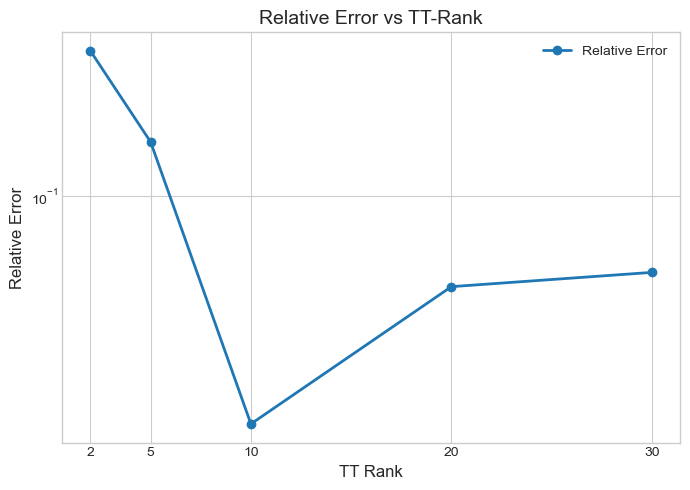

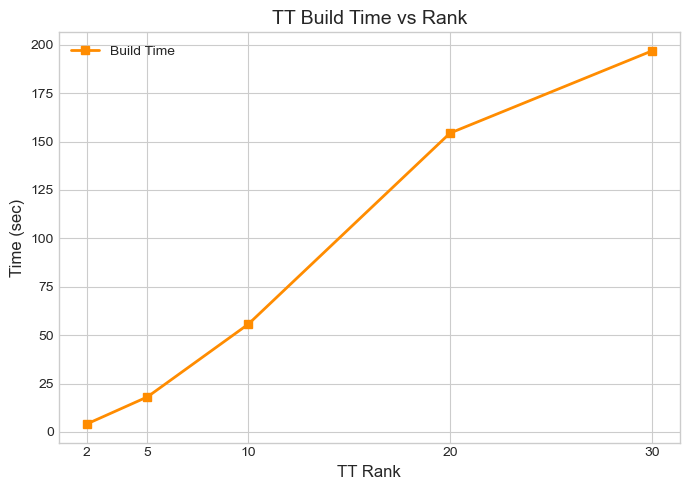

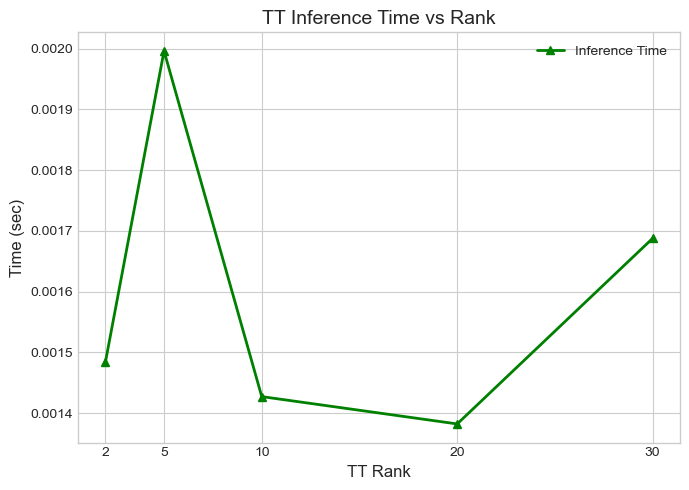

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from scipy.linalg import toeplitz
from itertools import product
from tntorch import cross
import torch
import time

# -----------------------------
# parameters
# -----------------------------
d = 4
T = 1.0
K = 1.0
omega = np.ones(d) / d

n_grid = 10
n_sigma = 5
n_rho = 5
mu_sigma = 0.2
tau_sigma = 0.05

sigma_vals = np.linspace(0.1, 0.3, n_sigma)
rho_vals = np.linspace(0.2, 0.8, n_rho)
sigma_rho_grid = list(product(sigma_vals, rho_vals))

# σ weights（guassian）× ρ weights（uniform）
pdf_sigma_vals = norm.pdf(sigma_vals, loc=mu_sigma, scale=tau_sigma)
pdf_sigma_vals /= np.sum(pdf_sigma_vals)
pdf_rho_vals = np.ones(n_rho) / n_rho

pdf_grid_weights = np.array([
    pdf_sigma_vals[i] * pdf_rho_vals[j]
    for i in range(n_sigma)
    for j in range(n_rho)
])

# -----------------------------
# grid form
# -----------------------------
grids_x = [np.linspace(-4 * sigma_vals.max(), 4 * sigma_vals.max(), n_grid) for _ in range(d)]
dx = np.array([np.diff(g).mean() for g in grids_x])
vol = np.prod(dx)

# -----------------------------
# 协方差矩阵构造
# -----------------------------
def generate_toeplitz_cov(d, sigma_val, rho):
    base = [rho ** i for i in range(d)]
    A = toeplitz(base)
    return sigma_val**2 * T * A

# -----------------------------
# Payoff 函数
# -----------------------------
def basket_payoff(x, K=1.0):
    s = np.exp(x)
    return max(np.dot(omega, s) - K, 0.0)

# -----------------------------
# Monte Carlo 参考价格
# -----------------------------
def monte_carlo_price_random_cov(n_samples=30000):
    samples = []
    for _ in range(n_samples):
        sigma_sample = np.random.normal(mu_sigma, tau_sigma)
        if sigma_sample <= 0:
            continue
        rho_sample = np.random.uniform(0.2, 0.8)
        cov = generate_toeplitz_cov(d, sigma_sample, rho_sample)
        mu = -0.5 * np.diag(cov)
        x = np.random.multivariate_normal(mu, cov)
        s = np.exp(x)
        payoff = max(np.dot(omega, s) - K, 0.0)
        samples.append(payoff)
    return np.mean(samples)

price_mc = monte_carlo_price_random_cov()
print(f"Monte Carlo (random σ, ρ) price: {price_mc:.6f}")

# -----------------------------
# 归一化常数 Z_sigma_rho
# -----------------------------
Z_sigma_rho = []
for sigma_val, rho_val in sigma_rho_grid:
    cov = generate_toeplitz_cov(d, sigma_val, rho_val)
    mu = -0.5 * np.diag(cov)
    total = 0.0
    for idx in product(*[range(n_grid)] * d):
        x = np.array([grids_x[i][idx[i]] for i in range(d)])
        total += multivariate_normal.pdf(x, mean=mu, cov=cov)
    Z = total * vol
    Z_sigma_rho.append(Z)

# -----------------------------
# 核函数 f(x, σ, ρ)
# -----------------------------
def f_tt_sigma(*indices):
    n_points = len(indices[0])
    results = []
    for j in range(n_points):
        x = np.array([
            grids_x[i][int(indices[i][j].item() if hasattr(indices[i][j], 'item') else indices[i][j])]
            for i in range(d)
        ])
        grid_idx = int(indices[-1][j])  # σ-ρ组合索引
        sigma_val, rho_val = sigma_rho_grid[grid_idx]
        weight = pdf_grid_weights[grid_idx]
        Z = Z_sigma_rho[grid_idx]

        cov = generate_toeplitz_cov(d, sigma_val, rho_val)
        mu = -0.5 * np.diag(cov)

        if Z == 0.0:
            results.append([0.0])
            continue

        pdf_val = multivariate_normal.pdf(x, mean=mu, cov=cov) / Z
        payoff = basket_payoff(x, K)
        results.append([payoff * pdf_val * weight])

    return torch.tensor(results, dtype=torch.float32)

# -----------------------------
# TT-Cross 主循环封装函数
# -----------------------------
def run_tt_cross(
    rank_list,
    f_tt_func,
    tt_input_shape,
    volume_element,
    price_mc_ref,
    n_trials=3,
    verbose=True
):
    results = []
    for rank in rank_list:
        if verbose:
            print(f"\n[Running TT-Cross] Rank ≤ {rank}")
        price_list = []
        time_list = []
        inference_list = []

        for _ in range(n_trials):
            start = time.time()
            tt_tensor = cross(
                f_tt_func,
                tt_input_shape,
                ranks_tt=rank,
                rmax=rank,
                eps=1e-3,
                verbose=False
            )
            build_time = time.time() - start

            start_infer = time.time()
            price = float(tt_tensor.sum()) * volume_element
            infer_time = time.time() - start_infer

            price_list.append(price)
            time_list.append(build_time)
            inference_list.append(infer_time)

        price_array = np.array(price_list)
        abs_error = np.abs(price_array - price_mc_ref)
        rel_error = abs_error / price_mc_ref

        results.append({
            'rank': rank,
            'mean_price': price_array.mean(),
            'abs_error_mean': abs_error.mean(),
            'rel_error_mean': rel_error.mean(),
            'build_time': np.mean(time_list),
            'inference_time': np.mean(inference_list)
        })

        if verbose:
            print(f"  Avg Price      : {price_array.mean():.6f}")
            print(f"  Abs Error Mean : {abs_error.mean():.2e}")
            print(f"  Rel Error Mean : {rel_error.mean():.2%}")
            print(f"  Build Time     : {np.mean(time_list):.2f}s")
            print(f"  Inference Time : {np.mean(inference_list):.4f}s")

    return results

# -----------------------------
# 图表绘制函数
# -----------------------------
def plot_tt_results(results):
    ranks = [r['rank'] for r in results]
    rel_errors = [r['rel_error_mean'] for r in results]
    build_times = [r['build_time'] for r in results]
    infer_times = [r['inference_time'] for r in results]

    plt.style.use('seaborn-v0_8-whitegrid')

    # 图 1：相对误差 vs TT-rank
    plt.figure(figsize=(7, 5))
    plt.plot(ranks, rel_errors, marker='o', linewidth=2, label='Relative Error')
    plt.title('Relative Error vs TT-Rank', fontsize=14)
    plt.xlabel('TT Rank', fontsize=12)
    plt.ylabel('Relative Error', fontsize=12)
    plt.xticks(ranks)
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 图 2：构造时间 vs TT-rank
    plt.figure(figsize=(7, 5))
    plt.plot(ranks, build_times, marker='s', linewidth=2, color='darkorange', label='Build Time')
    plt.title('TT Build Time vs Rank', fontsize=14)
    plt.xlabel('TT Rank', fontsize=12)
    plt.ylabel('Time (sec)', fontsize=12)
    plt.xticks(ranks)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 图 3：推理时间 vs TT-rank
    plt.figure(figsize=(7, 5))
    plt.plot(ranks, infer_times, marker='^', linewidth=2, color='green', label='Inference Time')
    plt.title('TT Inference Time vs Rank', fontsize=14)
    plt.xlabel('TT Rank', fontsize=12)
    plt.ylabel('Time (sec)', fontsize=12)
    plt.xticks(ranks)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 主调用逻辑
# -----------------------------
tt_input_shape = [n_grid] * d + [n_sigma * n_rho]
rank_list = [2, 5, 10, 20, 30]

results = run_tt_cross(
    rank_list=rank_list,
    f_tt_func=f_tt_sigma,
    tt_input_shape=tt_input_shape,
    volume_element=vol,
    price_mc_ref=price_mc,
    n_trials=3,
    verbose=True
)

plot_tt_results(results)


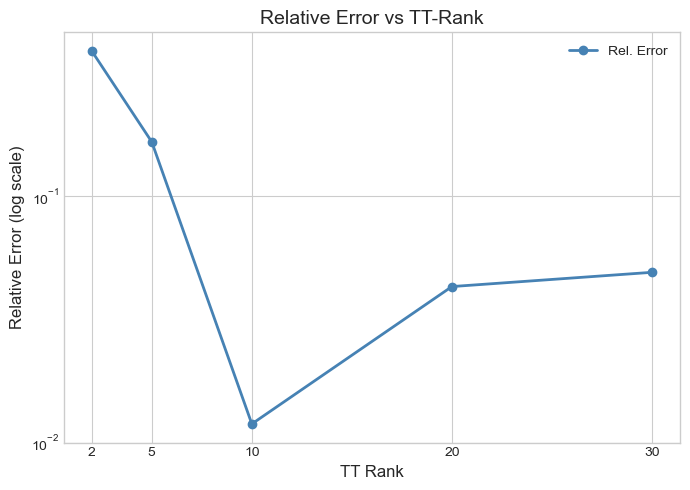

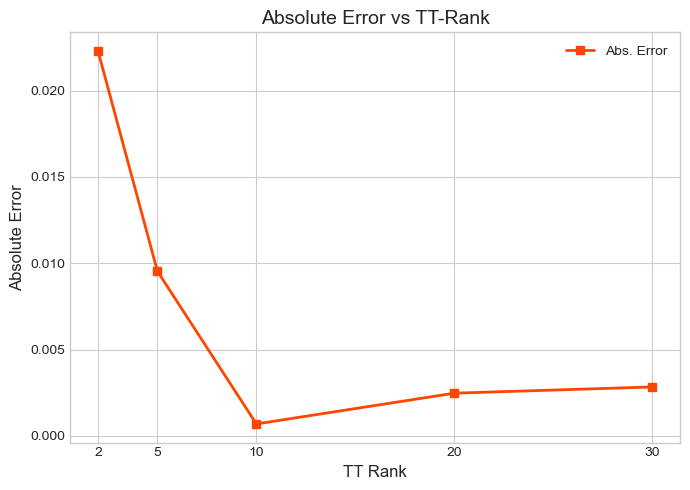

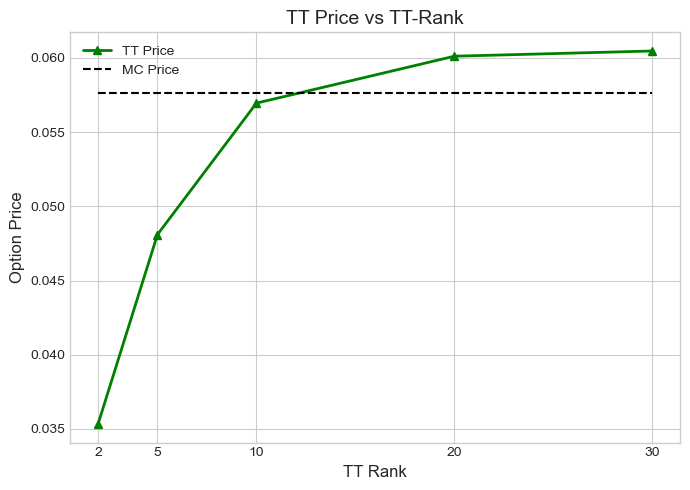

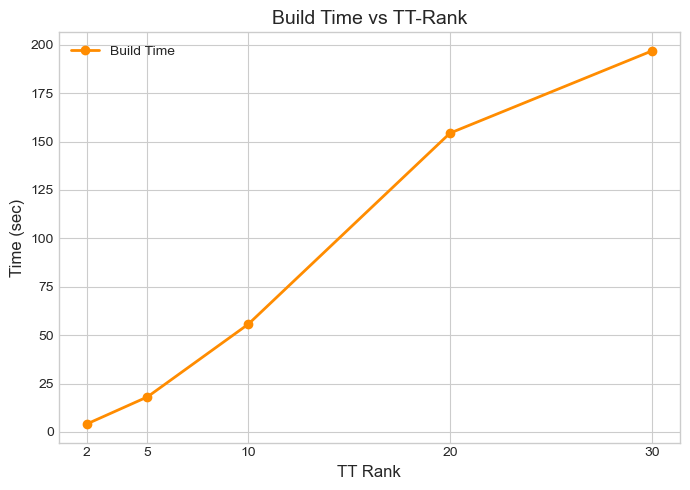

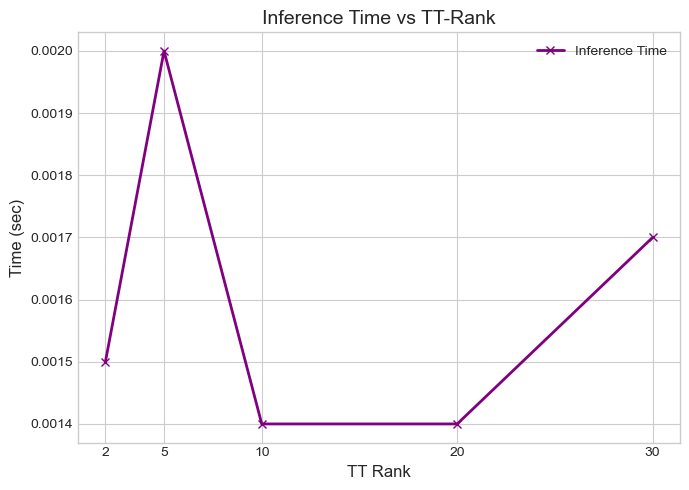

In [5]:
import matplotlib.pyplot as plt

# 数据
ranks = [2, 5, 10, 20, 30]
avg_price = [0.035341, 0.048097, 0.056951, 0.060112, 0.060464]
abs_error = [0.0223, 0.00954, 0.000687, 0.00247, 0.00283]
rel_error = [0.3868, 0.1655, 0.0119, 0.0429, 0.0490]
build_time = [4.13, 18.10, 55.67, 154.39, 196.82]
inference_time = [0.0015, 0.0020, 0.0014, 0.0014, 0.0017]
mc_price = 0.057638

plt.style.use('seaborn-v0_8-whitegrid')

# 图 1: Relative Error (log y)
plt.figure(figsize=(7,5))
plt.plot(ranks, rel_error, marker='o', linewidth=2, color='steelblue', label='Rel. Error')
plt.yscale('log')
plt.title("Relative Error vs TT-Rank", fontsize=14)
plt.xlabel("TT Rank", fontsize=12)
plt.ylabel("Relative Error (log scale)", fontsize=12)
plt.xticks(ranks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 图 2: Absolute Error
plt.figure(figsize=(7,5))
plt.plot(ranks, abs_error, marker='s', linewidth=2, color='orangered', label='Abs. Error')
plt.title("Absolute Error vs TT-Rank", fontsize=14)
plt.xlabel("TT Rank", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.xticks(ranks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 图 3: Avg Price vs MC Price
plt.figure(figsize=(7,5))
plt.plot(ranks, avg_price, marker='^', linewidth=2, color='green', label='TT Price')
plt.hlines(mc_price, ranks[0], ranks[-1], colors='black', linestyles='dashed', label='MC Price')
plt.title("TT Price vs TT-Rank", fontsize=14)
plt.xlabel("TT Rank", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.xticks(ranks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 图 4: Build Time
plt.figure(figsize=(7,5))
plt.plot(ranks, build_time, marker='o', linewidth=2, color='darkorange', label='Build Time')
plt.title("Build Time vs TT-Rank", fontsize=14)
plt.xlabel("TT Rank", fontsize=12)
plt.ylabel("Time (sec)", fontsize=12)
plt.xticks(ranks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 图 5: Inference Time
plt.figure(figsize=(7,5))
plt.plot(ranks, inference_time, marker='x', linewidth=2, color='purple', label='Inference Time')
plt.title("Inference Time vs TT-Rank", fontsize=14)
plt.xlabel("TT Rank", fontsize=12)
plt.ylabel("Time (sec)", fontsize=12)
plt.xticks(ranks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
